# Composite plots

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
import netCDF4
from numba import jit
from numba import njit
import pandas as pd

In [178]:
#function calculates if the values in subseas_anomalies_composite are significant over 95%
def sign_mean_subseasAnomalies_composite(subseas_anomalies, num_samples, subseas_anomalies_composite, sign, event_times_region_spitsbergen):
    num_events = event_times_region_spitsbergen.shape[0] 
    subseas_anomalies_data = subseas_anomalies.data.reshape((subseas_anomalies.data.shape[0],subseas_anomalies.data.shape[1]*subseas_anomalies.data.shape[2]))
    random_subseas_anomalies_composite = mean_subseasAnomalies_dist(subseas_anomalies_data, num_events, num_samples).reshape((num_samples, subseas_anomalies.data.shape[1], subseas_anomalies.data.shape[2]))
    random_subseas_anomalies_composite_5thperc = np.percentile(random_subseas_anomalies_composite, 100-sign, axis=0)
    random_subseas_anomalies_composite_95thperc = np.percentile(random_subseas_anomalies_composite, sign, axis=0)
    sign95_subseas_anomalies_composite = np.logical_or((subseas_anomalies_composite < random_subseas_anomalies_composite_5thperc),(subseas_anomalies_composite > random_subseas_anomalies_composite_95thperc)).astype(np.int32)
    
    return sign95_subseas_anomalies_composite

In [179]:
#function calculates num_samples of mean values for every grid point for num_events time points
#resulting in a normal distribution
@njit
def mean_subseasAnomalies_dist(subseas_anomalies_data, num_events, num_samples):
    random_event_times = np.zeros(num_events).astype(np.int32)
    random_subseas_anomalies_composite = np.zeros((num_samples,subseas_anomalies_data.shape[1]))
    
    for n in range(num_samples):
        for i in range(num_events):
            random_event_times[i] = np.random.randint(0,subseas_anomalies_data.shape[0]-1)
        for k in range(subseas_anomalies_data.shape[1]):
            random_subseas_anomalies_composite[n,k] = np.mean(subseas_anomalies_data[random_event_times, k])
    return random_subseas_anomalies_composite

In [180]:
def get_timesteps():
    # time steps for NDJFM daily data from 1979-2019(JFM) with 14690 time steps in total and with 6130 time steps
    # for only ndjfm
    time_steps = []
    counter = 0
    for i in range(1, 14691):
        if counter <= 90 or counter > 304:
            time_steps.append(i)
        counter += 1
        if counter == 366:
            counter = 1
    return np.array(time_steps)

### Configurations

In [181]:
file_path = '../data/'
file_path2 = 'Composite_Plots/'

# files to read
asp_ece_times = 'ASP_ECEs_times.txt'
pasp_ece_times = 'PASP_ECEs_times.txt'
wesp_ece_times = 'WESP_ECEs_times.txt'
spkaz_ece_times = 'SPKAZ_ECEs_times.txt'
sprus_ece_times = 'SPRUS_ECEs_times.txt'
spam_ece_times = 'SPAM_ECEs_times.txt'

spitsbergen_clean_ece_ts = 'spitsbergen_clean_ece_timeserie.txt'
arabiansea_clean_ece_ts = 'arabiansea_clean_ece_timeserie.txt'
pacific_clean_ece_ts = 'pacific_clean_ece_timeserie.txt'
westafrica_clean_ece_ts = 'westafrica_clean_ece_timeserie.txt'
kazakhstan_clean_ece_ts = 'kazakhstan_clean_ece_timeserie.txt'
northwestrussia_clean_ece_ts = 'northwestrussia_clean_ece_timeserie.txt'
northamerica_clean_ece_ts = 'northamerica_clean_ece_timeserie.txt'

file_slp_subseas = 'slp.4dx4dy.nh_ndjfm_19792019_subseas.nc'
file_v_250_subseas = 'v_250.4dx4dy.daymean.N.ndjfm.19792019_subseas.nc'
file_gph_50_subseas = 'gph_050.4dx4dy.daymean.N.ndjfm.19792019_subseas.nc'

In [182]:
# choose here which climotoligal variable you want to check
slp = 1
v_250 = 0
gph_50 = 0

In [183]:
# choose here the region you want to check with spitsbergen
arabiansea = 0
westafrica = 0
pacific = 0
kazakhstan = 0
northamerica = 1
northwestrussia = 0

In [184]:
taumax = 16
ts = get_timesteps()

In [185]:
# for plotting a square around spitsbergen
spitsbergen_box_vertices_lons = np.array([9., 24.75, 24.75, 9., 9.])
spitsbergen_box_vertices_lats = np.array([79.672035, 79.672035, 76.2997  , 76.2997  , 79.672035])
clean_extreme_events_spitsbergen = np.loadtxt(file_path + spitsbergen_clean_ece_ts, dtype=int)

In [186]:
if arabiansea:
    event_times_region_spitsbergen = np.loadtxt(file_path + asp_ece_times, dtype=int)
    clean_extreme_events_region = np.loadtxt(file_path + arabiansea_clean_ece_ts, dtype=int)
    region_str = 'arabiansea'
    region_name = 'Arabian Sea'
    region_box_vertices_lons = np.array([56, 66, 66, 56, 56])
    region_box_vertices_lats = np.array([25, 25, 15, 15, 25])
    region_to_spitsbergen = 1
    spitsbergen_to_region = 0
    
elif westafrica:
    event_times_region_spitsbergen = np.loadtxt(file_path + wesp_ece_times, dtype=int)
    clean_extreme_events_region = np.loadtxt(file_path + westafrica_clean_ece_ts, dtype=int)
    region_str = 'westafrica'
    region_name = 'West Africa'
    region_box_vertices_lons = np.array([-33, -15, -15, -33, -33])
    region_box_vertices_lats = np.array([22, 22, 12, 12, 22])
    region_to_spitsbergen = 1
    spitsbergen_to_region = 0
    
elif pacific:
    event_times_region_spitsbergen = np.loadtxt(file_path + pasp_ece_times, dtype=int)
    clean_extreme_events_region = np.loadtxt(file_path + pacific_clean_ece_ts, dtype=int)
    region_str = 'pacific'
    region_name = 'Pacific'
    region_box_vertices_lons = np.array([150, 160, 160, 150, 150])
    region_box_vertices_lats = np.array([33, 33, 22, 22, 33])
    region_to_spitsbergen = 1
    spitsbergen_to_region = 0
    
elif kazakhstan:
    event_times_region_spitsbergen = np.loadtxt(file_path + spkaz_ece_times, dtype=int)
    clean_extreme_events_region = np.loadtxt(file_path + kazakhstan_clean_ece_ts, dtype=int)
    region_str = 'kazakhstan'
    region_name = 'Kazakhstan'
    region_box_vertices_lons = np.array([68, 82, 82, 68, 68]) 
    region_box_vertices_lats = np.array([45, 45, 42, 42, 45])
    region_to_spitsbergen = 0
    spitsbergen_to_region = 1

elif northwestrussia:
    event_times_region_spitsbergen = np.loadtxt(file_path + sprus_ece_times, dtype=int)
    clean_extreme_events_region = np.loadtxt(file_path + northwestrussia_clean_ece_ts, dtype=int)
    region_str = 'northwestrussia'
    region_name = 'Northwest Russia'
    region_box_vertices_lons = np.array([33, 63, 63, 33, 33])
    region_box_vertices_lats = np.array([63, 63, 55, 55, 63])
    region_to_spitsbergen = 0
    spitsbergen_to_region = 1

elif northamerica:
    event_times_region_spitsbergen = np.loadtxt(file_path + spam_ece_times, dtype=int)
    clean_extreme_events_region = np.loadtxt(file_path + northamerica_clean_ece_ts, dtype=int)
    region_str = 'northamerica'
    region_name = 'North America'
    region_box_vertices_lons = np.array([-108,  -88,  -88, -108, -108]) 
    region_box_vertices_lats = np.array([60, 60, 51, 51, 60])
    region_to_spitsbergen = 0
    spitsbergen_to_region = 1
    

### Reading data, prepping the data to be plotted and calculating significant values

In [187]:
dataset = netCDF4.Dataset(file_path + file_slp_subseas, 'r')
# nh from 1979-2019(NDJFM) with seasonality subtracted
slp_subseas = dataset.variables['MSL'][:]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:] 

slp_subseas_data = np.reshape(slp_subseas,(slp_subseas.shape[0],slp_subseas.shape[1]*slp_subseas.shape[2])).T

slp_subseas_anomalies = slp_subseas - slp_subseas.sum(axis=0)/slp_subseas.shape[0]

slp_subseas_anomalies_composite = slp_subseas_anomalies[event_times_region_spitsbergen, :, :].sum(axis=0)/slp_subseas_anomalies[event_times_region_spitsbergen, :, :].shape[0]

slp_subseas_std = slp_subseas.data.std(axis=0)

sign95_slp_subseas_anomalies_composite = sign_mean_subseasAnomalies_composite(slp_subseas_anomalies, 10000, slp_subseas_anomalies_composite, 97.5, event_times_region_spitsbergen)

In [188]:
dataset2 = netCDF4.Dataset(file_path + file_v_250_subseas, 'r')
# nh from 1979-2019(NDJFM) with seasonality subtracted
v_250_subseas = dataset2.variables['V'][:]
plev = dataset2.variables['plev'][:]
lats2 = dataset2.variables['lat'][:]
lons2 = dataset2.variables['lon'][:] 

v_250_subseas_anomalies = (v_250_subseas - v_250_subseas.sum(axis=0)/v_250_subseas.shape[0])[:,0,:,:]

v_250_subseas_anomalies_composite = v_250_subseas_anomalies[event_times_region_spitsbergen, :, :].sum(axis=0)/v_250_subseas_anomalies[event_times_region_spitsbergen, :, :].shape[0]

v_250_subseas_std = v_250_subseas.data.std(axis=0)[0,:,:]

sign95_v_250_subseas_anomalies_composite = sign_mean_subseasAnomalies_composite(v_250_subseas_anomalies, 10000, v_250_subseas_anomalies_composite, 97.5, event_times_region_spitsbergen)

In [189]:
dataset3 = netCDF4.Dataset(file_path + file_gph_50_subseas, 'r')
# nh from 1979-2019(NDJFM) with seasonality subtracted
gph_50_subseas = dataset3.variables['Z'][:]
plev2 = dataset3.variables['plev'][:]
lats3 = dataset3.variables['lat'][:]
lons3 = dataset3.variables['lon'][:] 

gph_50_subseas_anomalies = (gph_50_subseas - gph_50_subseas.sum(axis=0)/gph_50_subseas.shape[0])[:,0,:,:]

gph_50_subseas_anomalies_composite = gph_50_subseas_anomalies[event_times_region_spitsbergen, :, :].sum(axis=0)/gph_50_subseas_anomalies[event_times_region_spitsbergen, :, :].shape[0]

gph_50_subseas_std = gph_50_subseas.data.std(axis=0)[0,:,:]

sign95_gph_50_subseas_anomalies_composite = sign_mean_subseasAnomalies_composite(gph_50_subseas_anomalies, 10000, gph_50_subseas_anomalies_composite, 97.5, event_times_region_spitsbergen)

In [190]:
if slp:
    subseas_anomalies = slp_subseas_anomalies
    subseas_anomalies_composite = slp_subseas_anomalies_composite
    std = slp_subseas_std
    sign95_subseas_anomalies_composite = sign95_slp_subseas_anomalies_composite
    title_before_after = 'Composite anomalies of slp with respect to NDJFM climatology \n'
    title = 'Composite anomalies of slp with respect to NDJFM climatology'
    levels = np.linspace(-6, 6, 25).tolist()
    unit = 'hPa'
    save_title_before_after = 'composite_plot_slp_sptisbergen_'+region_str+'_taumax'
    save_title = 'composite_plot_slp_sptisbergen_'+region_str+'_event_times_taumax'
    file_path1 = 'NDJFM/'
    
elif v_250:
    subseas_anomalies = v_250_subseas_anomalies
    subseas_anomalies_composite = v_250_subseas_anomalies_composite
    std = v_250_subseas_std
    sign95_subseas_anomalies_composite = sign95_v_250_subseas_anomalies_composite
    title_before_after = 'Composite anomalies of v(250hPa) with respect to NDJFM climatology \n'
    title = 'Composite anomalies of v(250hPa) with respect to NDJFM climatology'
    levels = np.linspace(-6, 6, 25).tolist()
    unit = 'm/s'
    save_title_before_after = 'composite_plot_v250_sptisbergen_'+region_str+'_taumax'
    save_title = 'composite_plot_v250_sptisbergen_'+region_str+'_event_times_taumax'
    file_path1 = 'v_250/'

elif gph_50:
    subseas_anomalies = gph_50_subseas_anomalies
    subseas_anomalies_composite = gph_50_subseas_anomalies_composite
    std = gph_50_subseas_std
    sign95_subseas_anomalies_composite = sign95_gph_50_subseas_anomalies_composite
    title_before_after = 'Composite anomalies of gph(50hPa) with respect to NDJFM climatology \n'
    title = 'Composite anomalies of gph(50hPa) with respect to NDJFM climatology'
    levels = np.linspace(-90, 90, 25).tolist()
    unit = 'm'
    save_title_before_after = 'composite_plot_gph50_sptisbergen_'+region_str+'_taumax'
    save_title = 'composite_plot_gph50_sptisbergen_'+region_str+'_event_times_taumax'
    file_path1 = 'gph50/'

In [191]:
if region_to_spitsbergen:
    # dataframe has clean events, time_steps and time indices in one dataframe
    df = pd.DataFrame({'events':clean_extreme_events_region, 'timesteps in days':ts})
elif spitsbergen_to_region:
    # dataframe has clean events, time_steps and time indices in one dataframe
    df = pd.DataFrame({'events':clean_extreme_events_spitsbergen, 'timesteps in days':ts})

### Plotting composite plot anomalies with respect to NDJFM climatology (subseas) for taumax days before and after

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-16


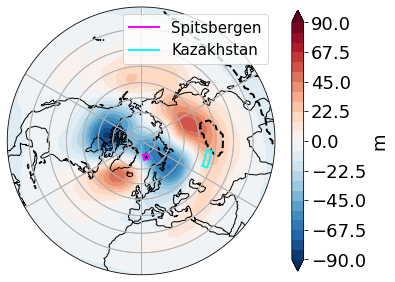

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-15


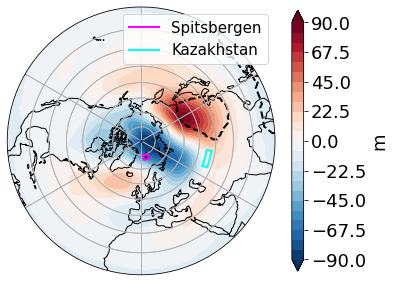

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-14


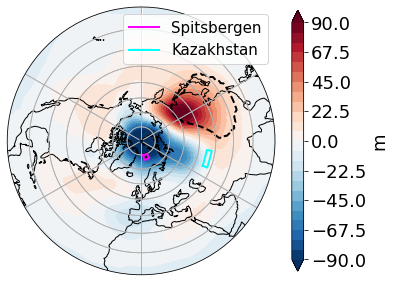

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-13


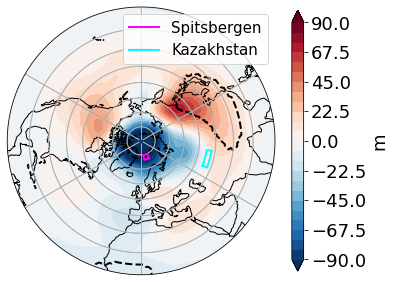

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-12


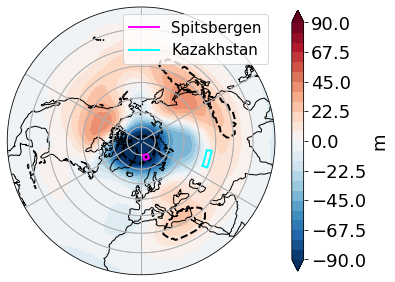

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-11


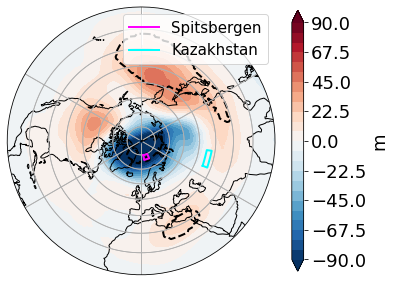

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-10


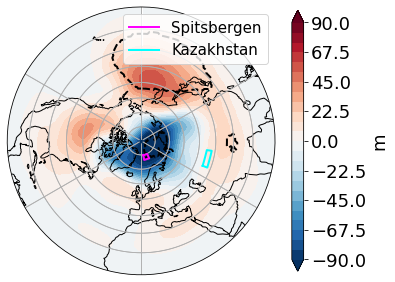

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-9


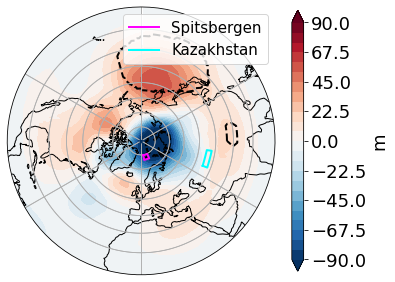

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-8


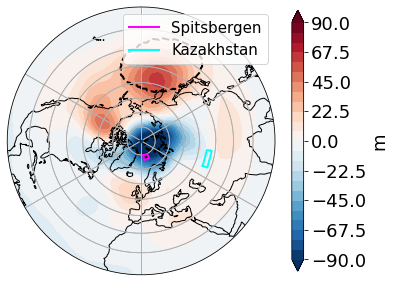

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-7


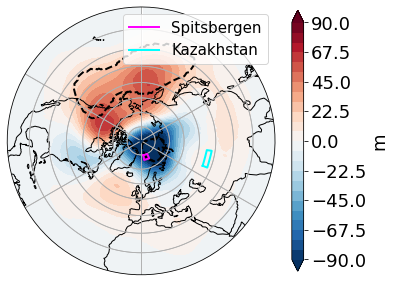

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-6


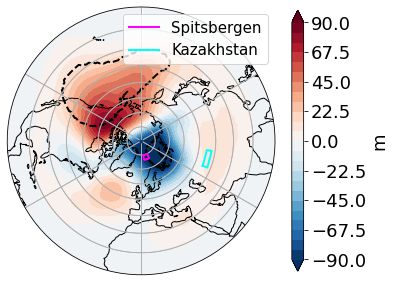

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-5


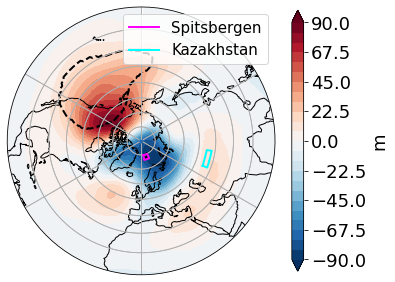

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-4


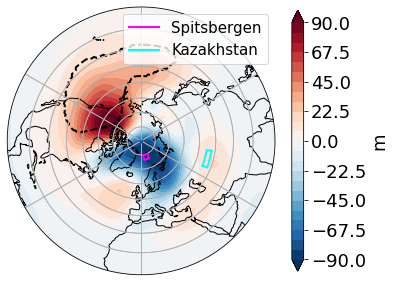

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-3


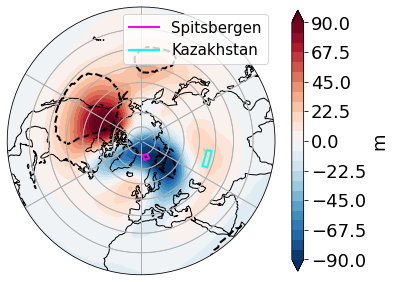

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-2


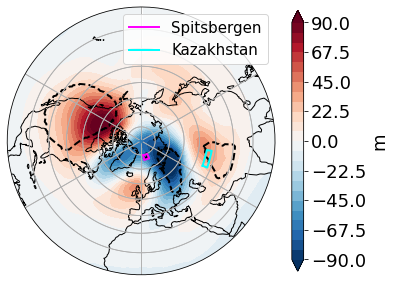

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


-1


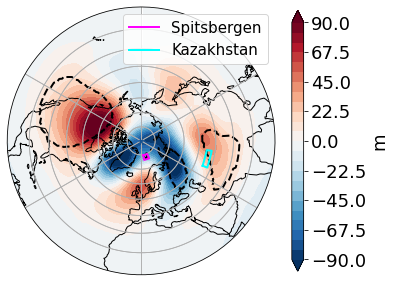

In [192]:
for i in np.array([16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]):
    event_times_region_spitsbergen_taumax_day_before = df.iloc[event_times_region_spitsbergen-i]['timesteps in days'].index.to_numpy()
    anomalies_composite_taumax_days_before_subseas = subseas_anomalies[event_times_region_spitsbergen_taumax_day_before, :, :].sum(axis=0)/subseas_anomalies[event_times_region_spitsbergen_taumax_day_before, :, :].shape[0]
    
    sign95_subseas_anomalies_composite_taumax_days_before = sign_mean_subseasAnomalies_composite(subseas_anomalies, 10000, anomalies_composite_taumax_days_before_subseas, 95, event_times_region_spitsbergen_taumax_day_before)
        
    #due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
    #smooths the connection plot 
    hacked_proj = ccrs.NorthPolarStereo()
    hacked_proj._threshold /= 100.
    clevs = levels

    f = plt.figure(figsize=(6, 12))#figsize=(6, 12)
    proj = hacked_proj   
  
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax = plt.axes(projection=proj)
    ax.coastlines()
    ax.set_global()
 
    gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
    gl.n_steps = 90
    
    #ax.set_title(title_before_after + str(i) + ' days before', fontsize=16)
    ax.gridlines()
    ax.set_extent([-180, 180, 90, 10], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

      
    subseas_map = ax.contourf(lons, lats, anomalies_composite_taumax_days_before_subseas,  levels=clevs, cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree())
    sign95_map = ax.contour(lons, lats, sign95_subseas_anomalies_composite_taumax_days_before, levels=[0,1], transform=ccrs.PlateCarree(), linestyles='dashed', linewidths=2, colors='black')

    cmap = plt.colorbar(subseas_map, ax=ax, shrink=0.4)
    cmap.set_label(unit,size=18)
    cmap.ax.tick_params(labelsize=18)

    plt.plot(spitsbergen_box_vertices_lons, spitsbergen_box_vertices_lats, color='magenta', linewidth=2, transform=ccrs.Geodetic(), label='Spitsbergen')
    plt.plot(region_box_vertices_lons, region_box_vertices_lats, color='aqua', linewidth=2, transform=ccrs.Geodetic(), label=region_name)
    
    plt.legend(fontsize=15)
    
    print('-'+str(i))
    
    plt.show()
   
    f.savefig(file_path + file_path2 + save_title_before_after + str(taumax) + '_' + str(i) + 'days_before' + '.png', bbox_inches='tight', dpi=f.dpi)
    f.savefig(file_path + file_path2 +  region_str + '_' + file_path1[:-1] + '_' + str(16-i) + '.png', bbox_inches='tight', dpi=f.dpi)

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


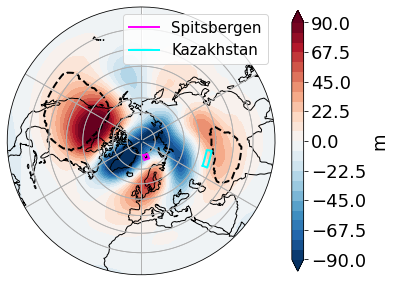

In [193]:
#due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
#smooths the connection plot 
hacked_proj = ccrs.NorthPolarStereo()
hacked_proj._threshold /= 100.

f = plt.figure(figsize=(6, 12))#figsize=(6, 12)
proj = hacked_proj   
clevs = levels
  
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
 
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
gl.n_steps = 90
    
#ax.set_title(title, fontsize=16)
ax.gridlines()
ax.set_extent([-180, 180, 90, 10], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

subseas_map = ax.contourf(lons, lats, subseas_anomalies_composite, cmap=plt.cm.RdBu_r, levels=clevs, extend='both', transform=ccrs.PlateCarree())
sign95_map = ax.contour(lons, lats, sign95_subseas_anomalies_composite, levels=[0,1], transform=ccrs.PlateCarree(), linestyles='dashed', linewidths=2, colors='black')

cmap = plt.colorbar(subseas_map, ax=ax,  shrink=0.4)
cmap.set_label(unit,size=18)
cmap.ax.tick_params(labelsize=18)

plt.plot(spitsbergen_box_vertices_lons, spitsbergen_box_vertices_lats, color='magenta', linewidth=2, transform=ccrs.Geodetic(), label='Spitsbergen')
plt.plot(region_box_vertices_lons, region_box_vertices_lats, color='aqua', linewidth=2, transform=ccrs.Geodetic(), label=region_name)

plt.legend(fontsize=15)
plt.show()
  
f.savefig(file_path + file_path2 + save_title + str(taumax) + '.png', bbox_inches='tight', dpi=f.dpi)
f.savefig(file_path + file_path2 + region_str + '_' + file_path1[:-1] + '_' + str(16) + '.png', bbox_inches='tight', dpi=f.dpi)

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


17


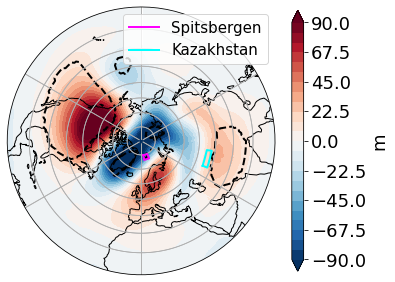

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


18


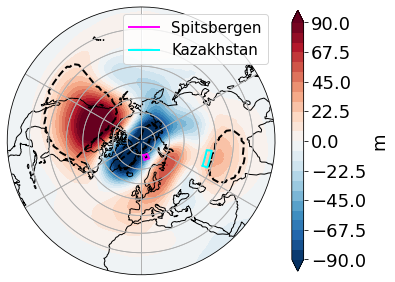

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


19


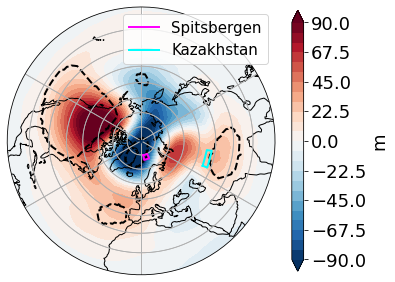

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


20


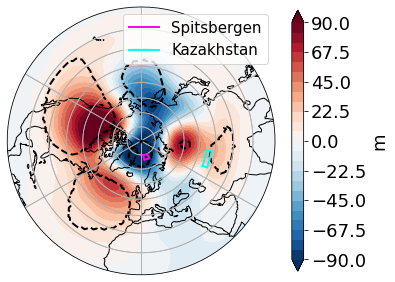

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


21


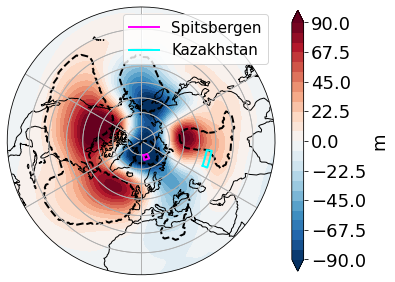

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


22


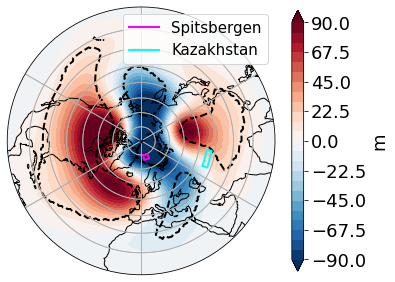

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


23


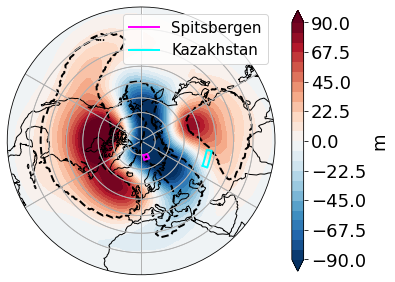

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


24


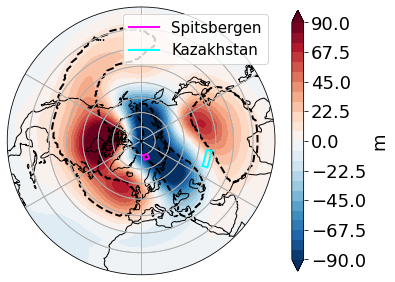

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


25


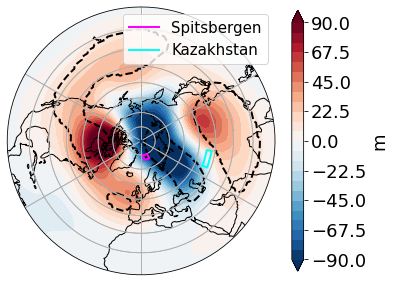

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


26


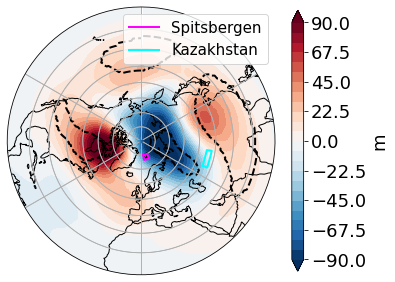

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


27


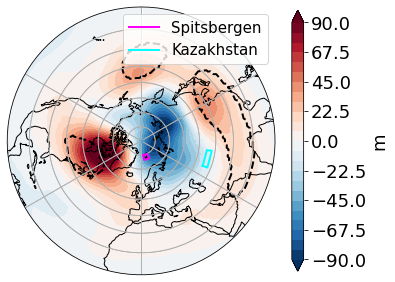

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


28


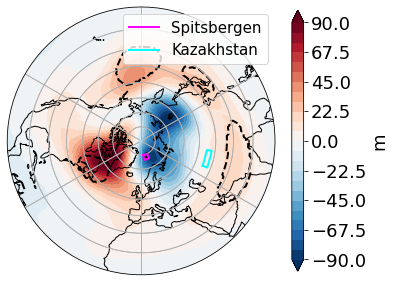

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


29


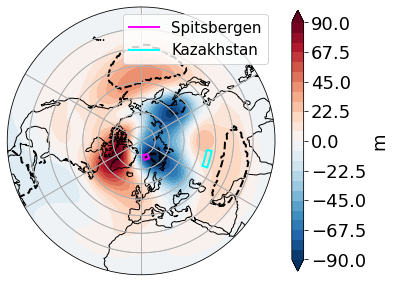

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


30


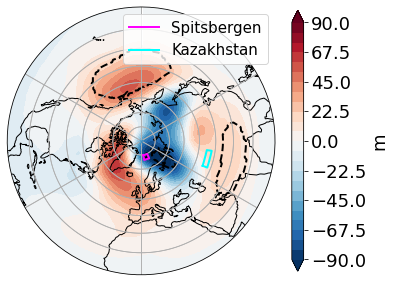

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


31


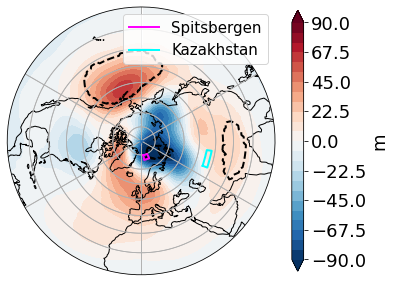

/home/mrerzincan/anaconda3/envs/mtplus/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


32


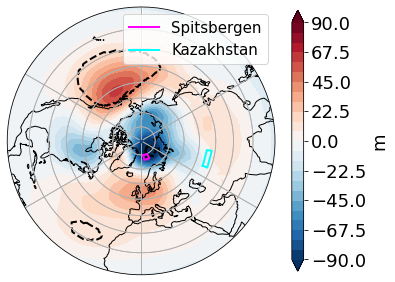

In [194]:
for i in np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]):
    event_times_region_spitsbergen_taumax_day_later = df.iloc[event_times_region_spitsbergen+i]['timesteps in days'].index.to_numpy()
    subseas_anomalies_composite_taumax_days_later = subseas_anomalies[event_times_region_spitsbergen_taumax_day_later, :, :].sum(axis=0)/subseas_anomalies[event_times_region_spitsbergen_taumax_day_later, :, :].shape[0]
    
    sign95_subseas_anomalies_composite_taumax_days_later = sign_mean_subseasAnomalies_composite(subseas_anomalies, 10000, subseas_anomalies_composite_taumax_days_later, 95, event_times_region_spitsbergen_taumax_day_later)

        
    #due to the default threshold being too large for this use case, the private _threshold attribute is divided by 100
    #smooths the connection plot 
    hacked_proj = ccrs.NorthPolarStereo()
    hacked_proj._threshold /= 100.
    clevs = levels

    f = plt.figure(figsize=(6, 12))#figsize=(6, 12)
    proj = hacked_proj   
  
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax = plt.axes(projection=proj)
    ax.coastlines()
    ax.set_global()
 
    gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)  #to have smoother gridlines/latitude-lines
    gl.n_steps = 90
    
    #ax.set_title(title_before_after + str(i) + ' days later', fontsize=16)
    ax.gridlines()
    ax.set_extent([-180, 180, 90, 10], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

      
    subseas_map = ax.contourf(lons, lats, subseas_anomalies_composite_taumax_days_later,  levels=clevs, cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree())
    sign95_map = ax.contour(lons, lats, sign95_subseas_anomalies_composite_taumax_days_later, levels=[0,1], transform=ccrs.PlateCarree(), linestyles='dashed', linewidths=2, colors='black')

    cmap = plt.colorbar(subseas_map, ax=ax, shrink=0.4)
    cmap.set_label(unit,size=18)
    cmap.ax.tick_params(labelsize=18)

    plt.plot(spitsbergen_box_vertices_lons, spitsbergen_box_vertices_lats, color='magenta', linewidth=2, transform=ccrs.Geodetic(), label='Spitsbergen')
    plt.plot(region_box_vertices_lons, region_box_vertices_lats, color='aqua', linewidth=2, transform=ccrs.Geodetic(), label=region_name)
    plt.legend(fontsize=15)
    
    print(str(16+i))
    
    plt.show()
   
    f.savefig(file_path + file_path2 + save_title_before_after + str(taumax) + '_' + str(i) + 'days_later' + '.png', bbox_inches='tight', dpi=f.dpi)
    f.savefig(file_path + file_path2 + region_str + '_' + file_path1[:-1] + '_' + str(16+i) + '.png', bbox_inches='tight', dpi=f.dpi)